# 1_esmprotein_multimer

In [1]:
from esm.sdk.api import ESMProtein, ProteinComplex
from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.types import FunctionAnnotation

In [2]:
fpath = '/home/jupyter/1BEY.pdb'
protein_chain = ProteinChain.from_pdb(fpath, chain_id='H')
monomer_protein = ESMProtein.from_protein_chain(protein_chain)

In [3]:
complex = ProteinComplex.from_pdb(fpath)
multimer_protein = ESMProtein.from_protein_complex(complex)
protein = multimer_protein # for convenience

In [4]:
print(protein.coordinates.shape)

torch.Size([425, 37, 3])


In [6]:
# Functions for visualizing 3D structure

import py3Dmol


def visualize_pdb(pdb_string):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.zoomTo()
    view.render()
    view.center()
    return view


def visualize_3D_coordinates(coordinates):
    """
    This uses all Alanines
    """
    protein_with_same_coords = ESMProtein(coordinates=coordinates)
    # pdb with all alanines
    pdb_string = protein_with_same_coords.to_pdb_string()
    return visualize_pdb(pdb_string)


def visualize_3D_protein(protein):
    pdb_string = protein.to_pdb_string()
    return visualize_pdb(pdb_string)

In [7]:
# visualize from just the coordinates
visualize_3D_coordinates(protein.coordinates)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Structure related functions (cool stuff)

In [36]:
from biotite.structure import annotate_sse


def get_approximate_ss(protein_chain: ProteinChain):
    # get biotite's ss3 representation
    ss3_arr = annotate_sse(protein_chain.atom_array)
    biotite_ss3_str = "".join(ss3_arr)

    # translate into ESM3's representation
    translation_table = str.maketrans(
        {
            "a": "H",  # alpha helix
            "b": "E",  # beta sheet
            "c": "C",  # coil
        }
    )
    esm_ss3 = biotite_ss3_str.translate(translation_table)
    return esm_ss3

In [37]:
protein.secondary_structure = get_approximate_ss(protein_chain)
print(protein.secondary_structure)

CEEEEEECCCCCCCCEEEEEEECCCCCCCCCEEEEEEEECCCEEEEECCCCCCCCCCCCCCCCCCCCCCEEEEECCCCCEEEEEECCCCCCCCCEEEEEEECCCCCCCCCCCCEEEEEECCCEEEEEEECCCCCCEEEEEECCCCCCEEEEECCCCCCCCCCCEEEEEECCCCEEEEEEEEECCCCCCCCEEEEEEECCCCCCCCCCCCC


In [38]:
# Slightly modified version of secondary structure plotting code from
# https://www.biotite-python.org/examples/gallery/structure/transketolase_sse.html
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import biotite
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


# Create 'FeaturePlotter' subclasses
# for drawing the secondary structure features
class HelixPlotter(graphics.FeaturePlotter):
    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2 * np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4 * np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2 * np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"])


class SheetPlotter(graphics.FeaturePlotter):
    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width

    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height / 2
        dx = bbox.width
        dy = 0

        if loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the previous or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(
            biotite.AdaptiveFancyArrow(
                x,
                y,
                dx,
                dy,
                self._tail_width * bbox.height,
                self._head_width * bbox.height,
                # Create head with 90 degrees tip
                # -> head width/length ratio = 1/2
                head_ratio=0.5,
                draw_head=draw_head,
                color=biotite.colors["orange"],
                linewidth=0,
            )
        )


# Converter for the DSSP secondary structure elements
# to the classical ones
dssp_to_abc = {
    "I": "c",
    "S": "c",
    "H": "a",
    "E": "b",
    "G": "c",
    "B": "b",
    "T": "c",
    "C": "c",
}


def visualize_secondary_structure(sse, first_id):
    """
    Helper function to convert secondary structure array to annotation
    and visualize it.
    """

    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "a":
            str_type = "helix"
        elif str_type == "b":
            str_type = "sheet"
        else:
            # coil
            return
        feature = seq.Feature(
            "SecStr", [seq.Location(first, last)], {"sec_str_type": str_type}
        )
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = seq.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i - 1]:
                _add_sec_str(
                    annotation, curr_start + first_id, i - 1 + first_id, curr_sse
                )
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start + first_id, i + first_id, curr_sse)

    fig = plt.figure(figsize=(30.0, 3.0))
    ax = fig.add_subplot(111)
    graphics.plot_feature_map(
        ax,
        annotation,
        symbols_per_line=150,
        loc_range=(first_id, first_id + len(sse)),
        feature_plotters=[HelixPlotter(), SheetPlotter()],
    )
    fig.tight_layout()
    return fig, ax


def plot_ss8(ss8_string):
    ss3 = np.array([dssp_to_abc[e] for e in ss8_string], dtype="U1")
    _, ax = visualize_secondary_structure(ss3, 1)
    ax.set_xticks([])

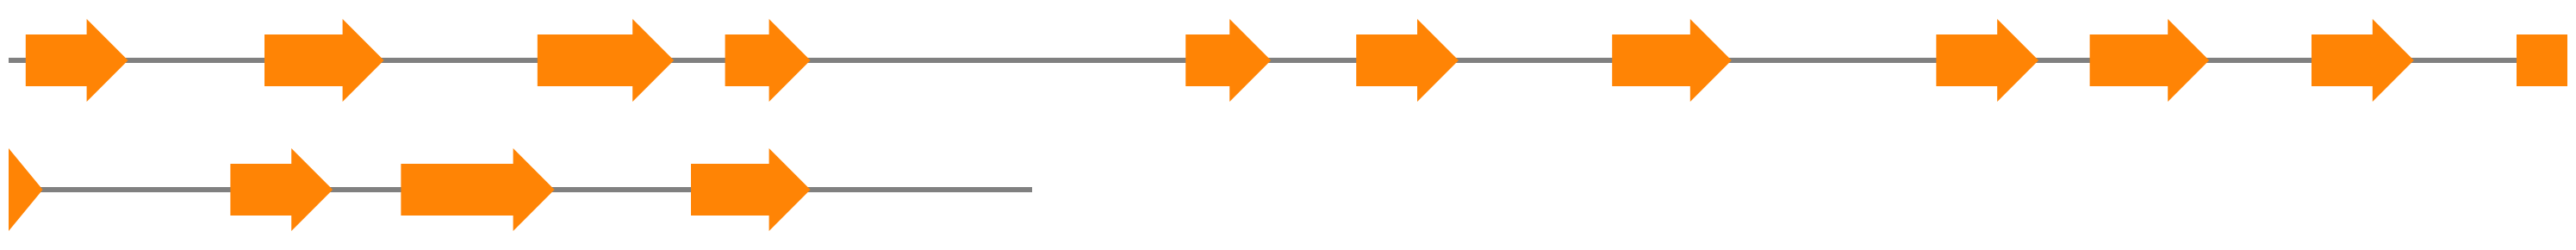

In [39]:
plot_ss8(protein.secondary_structure)

In [41]:
protein.sasa = protein_chain.sasa()

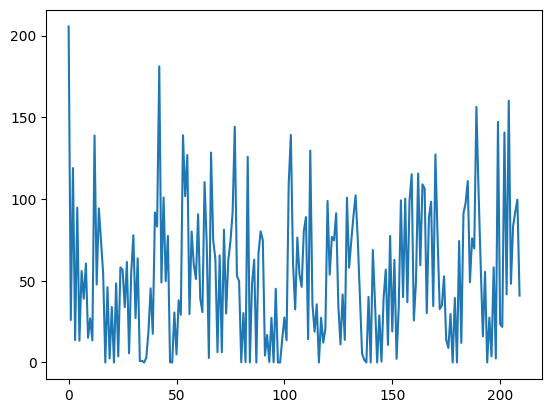

In [42]:
plt.plot(protein.sasa)

In [47]:
from matplotlib import colormaps

cmap = colormaps["cividis"]
clip_sasa_lower = 10
clip_sasa_upper = 90


def plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    _, ax = plt.subplots(figsize=(5, 0.3), dpi=350)
    ax.imshow(gradient, aspect="auto", cmap=cmap)
    ax.text(
        0.1,
        -0.3,
        f"{clip_sasa_lower} or lower",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.3,
        f"{(clip_sasa_lower + clip_sasa_upper) // 2}",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.3,
        f"{clip_sasa_upper} or higher",
        va="center",
        ha="left",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


# Functions for visualizing SASA as colors on the 3D structure


def get_color_strings(sasa, clip_sasa_lower, clip_sasa_upper, cmap):
    transformed_sasa = np.clip(sasa, clip_sasa_lower, clip_sasa_upper)
    transformed_sasa = (transformed_sasa - clip_sasa_lower) / (
        clip_sasa_upper - clip_sasa_lower
    )
    rgbas = (cmap(transformed_sasa) * 255).astype(int)

    return [f"rgb({rgba[0]},{rgba[1]},{rgba[2]})" for rgba in rgbas]


def visualize_sasa_3D_protein(
    protein, clip_sasa_lower=clip_sasa_lower, clip_sasa_upper=clip_sasa_upper, cmap=cmap
):
    pdb_string = protein.to_pdb_string()
    plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")

    for res_pos, res_color in enumerate(
        get_color_strings(protein.sasa, clip_sasa_lower, clip_sasa_upper, cmap)
    ):
        view.setStyle(
            {"chain": "A", "resi": res_pos + 1}, {"cartoon": {"color": res_color}}
        )
    view.zoomTo()
    view.render()
    view.center()

    return view

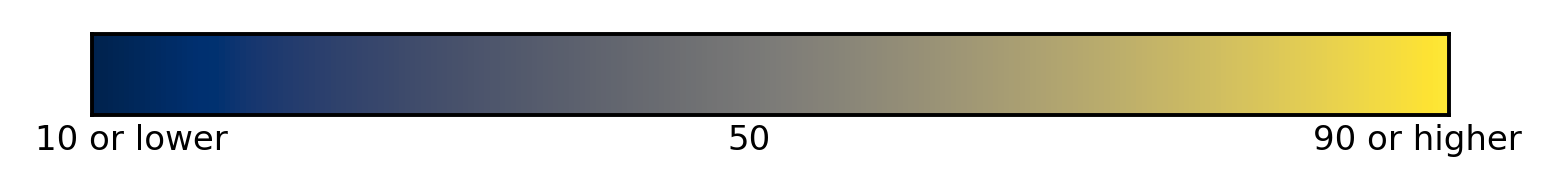

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [48]:
visualize_sasa_3D_protein(protein)

In [50]:
same_structure_protein = ESMProtein(coordinates=protein.coordinates)

In [51]:
same_structure_protein

ESMProtein(sequence=None, secondary_structure=None, sasa=None, function_annotations=None, coordinates=tensor([[[-11.9790,  53.3070,  56.1560],
         [-11.4090,  53.1340,  54.8040],
         [-12.5660,  52.9940,  53.8330],
         ...,
         [     nan,      nan,      nan],
         [     nan,      nan,      nan],
         [     nan,      nan,      nan]],

        [[-12.3640,  53.4150,  52.5840],
         [-13.4040,  53.3130,  51.5620],
         [-12.7190,  52.8970,  50.2780],
         ...,
         [     nan,      nan,      nan],
         [     nan,      nan,      nan],
         [     nan,      nan,      nan]],

        [[-12.2070,  51.6750,  50.2690],
         [-11.4950,  51.1060,  49.1230],
         [-11.8040,  51.8160,  47.8050],
         ...,
         [     nan,      nan,      nan],
         [     nan,      nan,      nan],
         [     nan,      nan,      nan]],

        ...,

        [[ 33.2800,  63.0640,  39.1170],
         [ 34.2360,  62.5460,  38.1630],
         [ 34.16